
 # Inferential Statistics

## PETE 2061 Lab 8

<a id='top'></a>

<a id='overview'></a>
# Topics Covered
<font color=blue>
 * [Confidence Intervals](#CI) 
 * [Bootstrapping](#bootstrap)
 * [Hypothesis Testing](#hypothesis)  
 * [P-values and confidence intervals](#p-value)
</font>
<br>

<a id='CI'> </a>
## Confidence Intervals
* poll.csv contains a poll for the favorite candidate to win an upcoming presidential election between Ed Orgeron (LSU coach) and Nick Saban (Alabama coach).
* This csv file contains the votes from a sample of 1,000 people. 
* We import required packages

In [6]:
import math
import io

In [7]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
import scipy.stats
import scipy.optimize
import scipy.spatial

* We import the 1000 polls stored in poll.csv

In [9]:
poll = pd.read_csv('poll.csv')

In [10]:
poll.info()  # this gives a summary of the columns and rows in this csv fiile, as well as the data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
vote    1000 non-null object
dtypes: object(1)
memory usage: 7.9+ KB


In [11]:
poll.head()   #displays first five entries in the data frame

,vote
0,Saban
1,Orgeron
2,Saban
3,Saban
4,Saban


In [12]:
poll['vote'].value_counts(normalize=True)  #this returns the normalized number of votes (proportions) for LSU and Bama. 
#Try running it with normalize=False

Saban      0.511
Orgeron    0.489
Name: vote, dtype: float64

* This data suggests that Nick Saban is more likely to win than Ed Orgeron.
* However, the limited sample means that this proportion depends on the actual potential voters that were polled.  
* This is known as **sampling variability**.
* Given this poll, what can we say about the underlying population of all potential voters? 
* To understand this, we need to study the sampling distribution of the proportion. 
* The goal is to understand what range of different samples we may get for the same population, and we will do this by computer simulation. 
* The simple function below simulates such a sample. 

In [13]:
def sample(sabanWinPercent,n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(n) < sabanWinPercent,'Saban','Orgeron')})

#Note the use of the function np.where(condition, result_if_true, result_if_false) 
#np.random.rand(n) generates 1000 (uniformly distributed) random samples ranging between 0 and 1.
#np.where stores "Saban" in the rows where the random number is less than 0.511, and "Orgeron" elsewhere.

In [14]:
s = sample(0.511,n=1000)   #0.511 is the Nick Saban's winning percentage in the sample of 1000 potential voters.

In [15]:
s.head()

,vote
0,Orgeron
1,Orgeron
2,Saban
3,Orgeron
4,Orgeron


In [16]:
s['vote'].value_counts(normalize=True)

Orgeron    0.506
Saban      0.494
Name: vote, dtype: float64

* For this randomly generated sample, Orgeron is actually predicted to win the election, even though the true Saban winning percentage is 51.1%. 
* So, depending on the sample you are looking at, Orgeron can actually be predicted to win the election, even though the true Saban win percentage is 51.1%. 
* We repeat this 1000 times and collect the results in a DataFrame called distDF. 

In [17]:
distDF = pd.DataFrame([sample(0.511)['vote'].value_counts(normalize=True) for i in range(1000)])
#recall list comprehension: [operation for i in range(1000)]
distDF.head()

,Saban,Orgeron
vote,0.502,0.498
vote,0.512,0.488
vote,0.510,0.490
vote,0.514,0.486
vote,0.513,0.487


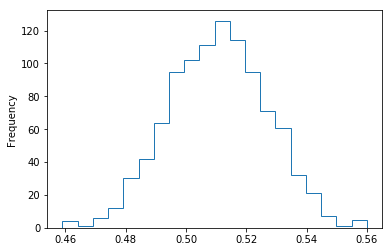

In [18]:
distDF['Saban'].plot(kind='hist',histtype='step',bins=20)
#distDF['Saban'].hist(histtype='step',bins=20)

* It turns out that for a true Saban winning percentage of 51.1%, we may obtain any sample winning percentage from 46% to 56%. 
* This means that the sample poll of 51.1% winning percentage for Saban could have originated from a voting population with Orgeron actually having a higher winning percentage.
* Can we make this more precise and identify a likely range of true winning percentages? 
* This leads to a very important notion in statistics, which is "confidence intervals".
* We can easily visualize the 95% confidence interval by displaying vertical lines at the 2.5th percentile and 97.5th percentile.
* This ensures that the area under the tail on both sides of the probability density function sums up to 5%, and the area within those two vertical lines sums up to 95%.

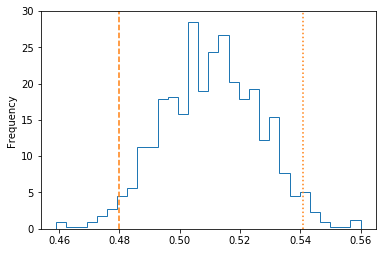

In [19]:
distDF['Saban'].plot(kind='hist',histtype='step',bins=30, density=True)
plt.axvline(distDF['Saban'].quantile(0.025), c='C1',linestyle='--')
#plt.axvline(distDF['Saban'].quantile(0.500), c='C1')
plt.axvline(distDF['Saban'].quantile(0.975), c='C1',linestyle=':')

* So, we can conclude that:
* 95% confidence interval is: [0.48,0.54]
* Estimate = 0.51 +/- 0.03 (at 95% confidence)
* Here, 0.51 is the **point estimate**, and 0.03 is the **margin of error** on either side of the point estimate.
* Therefore, the result of this election lies within the margin of error of the poll.
* This is not satisfying, so we need to increase the size of the sample.
* How much bigger does the sample need to be?
* We will determine this by computer simulation
* Let us implement the process of generating n different samples with a specified winning percentage in a function:

In [20]:
def samplingdist(sabanWinPercent,n=1000):
    return pd.DataFrame([sample(sabanWinPercent,n)['vote'].value_counts(normalize=True) for i in range(1000)])

We then create a quantile function that calls the samplingdist() function, and then computes and returns the 2.5th and 97.5th percentiles.

In [21]:
def quantiles(sabanWinPercent,n=1000):
    distDF = samplingdist(sabanWinPercent,n)
    return distDF['Saban'].quantile(0.025), distDF['Saban'].quantile(0.975)

In [22]:
quantiles(0.511)

(0.477, 0.541)

* This again confirms that the 95% confidence interval is: [0.48,0.54]
* Using the samplingdist() function, generate 10,000 samples with a Saban winning percentage of 50%
* Generate a histogram using the returned dataframe

In [23]:
distDF = samplingdist(0.50,10000)

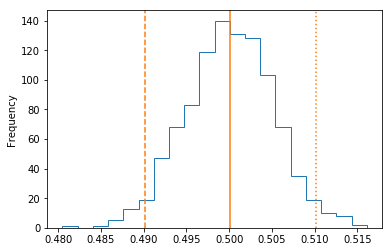

In [24]:
distDF['Saban'].plot(kind='hist', histtype='step',bins=20)
plt.axvline(distDF['Saban'].quantile(0.025), c='C1',linestyle='--')
plt.axvline(distDF['Saban'].quantile(0.500), c='C1')
plt.axvline(distDF['Saban'].quantile(0.975), c='C1',linestyle=':')

In [25]:
quantiles(0.5,10000)

(0.490695, 0.5098025)

* The plot and quantiles show that the 95% confidence interval is: [0.49,0.51]
* Estimate = 0.5 +/- 0.01 (at 95% confidence)
* This means that the margin of error lies within 1% when we use a sample size of 10,000.
* This would have been sufficient to claim Nick Saban as the likely winner of the election.
* Under very general conditions, one can show that the margin of error improves with square root of the number of samples
* Now load the large poll data, which is a sample of 10,000 voters

In [33]:
largepoll = pd.read_csv('poll-larger.csv')
largepoll['vote'].value_counts(normalize=True)

Orgeron    0.5181
Saban      0.4819
Name: vote, dtype: float64

* This poll of 10,000 potential voters indicates that the likely winner is actually Ed Orgeron and not Nick Saban.
* Can you compute the confidence interval for this winning percentage of Ed Orgeron, and show that he is the likely winner within a 95% confidence interval?
* Do you obtain a confidence interval between 50.8 and 52.8?

<a id='bootstrap'> </a>
## Bootstrapping
* In this section, we will import your grades in the multiple-choice part of the mid-term exam.
* The scores are reported as your raw score, out of a total of 50.

In [34]:
gradeDF = pd.read_csv('midterm_Part1.csv')

In [35]:
gradeDF.head()

,grade
0,28
1,48
2,50
3,44
4,38


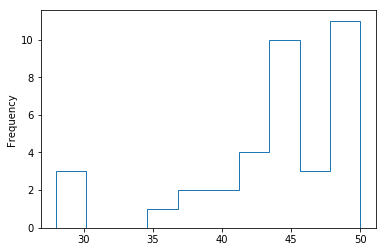

In [36]:
gradeDF['grade'].plot(kind='hist',histtype='step')

In [30]:
gradeDF.describe()

,grade
count,36.000000
mean,43.444444
std,5.628725
min,28.000000
25%,42.000000
50%,44.000000
75%,48.000000
max,50.000000


* The histogram has no recognizable simple form, but the mean for the sample is 43.44. 
* What can we say about the true mean value (if this is just a sample from PETE 2061 students)? 
* This time we cannot build a confidence interval by simulating the sampling distribution because we do not know how to describe it. 
* However, we can still use computing by adopting a powerful idea in modern statistics, called "bootstrapping".
* We will estimate the uncertainty in the mean of these grades by generating several samples from the one given. This is done by sampling with replacement as shown below.

In [31]:
gradeDF.sample(36,replace=True).describe()  #bootstrapping involves sampling with replacement using the sample() function

,grade
count,36.000000
mean,43.944444
std,4.622581
min,30.000000
25%,42.000000
50%,44.000000
75%,48.000000
max,50.000000


In [38]:
gradeDF.sample(36,replace=True)

,grade
28,48
31,48
32,42
33,42
32,42
26,50
5,36
28,48
14,46
34,30


* Observe that the mean of this bootstrapped sample is a little different from the mean of the original sample. 
* Now, we will generate 1000 bootstrapped samples, and store the means from these 1000 bootstrapped samples using Python list comprehension.
* We will then store these 1000 means into a dataframe, named "bootstrap".

In [177]:
bootstrap = pd.DataFrame({'meangrade': [gradeDF.sample(36,replace=True)['grade'].mean() for i in range(1000)]})

* Next, we generate a histogram of the means of these bootstrapped samples, and plot the original mean as a vertical line.
* We can now compute the confidence interval for the bootstrapped maen as shown.

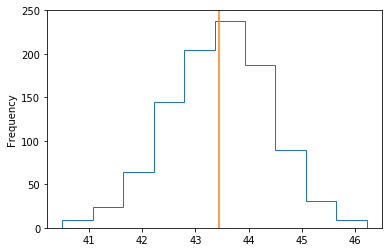

In [178]:
bootstrap['meangrade'].plot(kind="hist", histtype='step')
plt.axvline(gradeDF['grade'].mean(),color='C1') #this places a vertical line at the mean of the original scores

In [179]:
bootstrap['meangrade'].quantile(0.025), bootstrap['meangrade'].quantile(0.975)

(41.49861111111112, 45.223611111111104)

<a id='hypothesis'> </a>
## Hypothesis Testing
* 1854 in London was a very rough time because of the repeated and deadly epidemics of cholera. 
* Physician John Snow used simple statistics and elegant plotting, to pinpoint the origin of one such outbreaks to a contaminated water pump on Broad Street. 
* We are going to follow in John Snow's footsteps to learn about testing hypotheses.
* We load pumps.csv, which contains the positions of eight water pumps in Central London.
* The location of these 8 pumps are given as latitudes and longitudes. 
* The X- and Y- distances of each of these 8 pumps from pump #0 are also given in kilometers.
* Pump 0 is the reference pump, which will plot at point (0,0). All other spatial data are relative to its location.

In [40]:
pumps = pd.read_csv('pumps.csv')
pumps

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611
5,51.511542,-0.135919,0.051813,-0.199972
6,51.510019,-0.133962,0.187193,-0.369265
7,51.511295,-0.138199,-0.105910,-0.227428


* The cholera.csv dataset contains the number of deaths at different locations, as well as the closest pump to that location. 
* Let's look at one record in every 20 rows. 

In [41]:
cholera = pd.read_csv('cholera.csv')
cholera.loc[0::20] #what do you think this does? remember that the syntax is [start:stop:increment]

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
20,2,51.513441,-0.138762,-0.144856,0.011116,1
40,2,51.513025,-0.139036,-0.163811,-0.035126,1
60,1,51.512765,-0.137533,-0.059838,-0.064027,0
80,1,51.512782,-0.136819,-0.010446,-0.062137,0
100,4,51.512250,-0.135394,0.088131,-0.121273,5
120,1,51.513238,-0.134594,0.143473,-0.011449,4
140,1,51.512585,-0.134793,0.129707,-0.084035,4
160,1,51.514065,-0.134364,0.159384,0.080478,0
180,1,51.515149,-0.135395,0.088062,0.200973,0


* Both the pump and cholera data can be plotted as shown below:

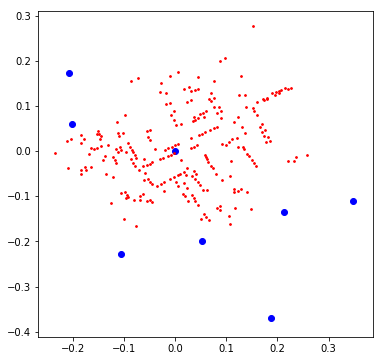

In [42]:
plt.figure(figsize=(6,6))
plt.scatter(pumps['x'], pumps['y'], color='b')           # the pumps are plotted as the blue dots
plt.scatter(cholera['x'], cholera['y'], color='r', s=3)  # the cholera deaths are plotted as red dots

* We can load a map image of London and plot the pump and cholera data over it as follows:

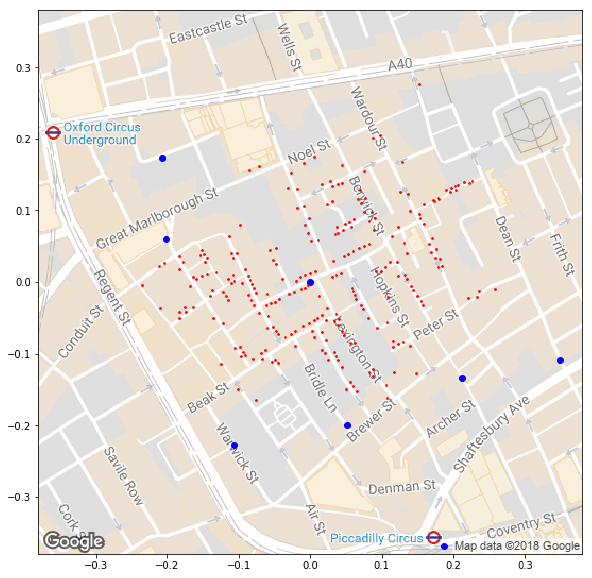

In [43]:
img = matplotlib.image.imread('london.png')
plt.figure(figsize=(10,10))
plt.imshow(img,extent=[-0.38,0.38,-0.38,0.38])

plt.scatter(pumps['x'], pumps['y'], color='b')           # the pumps are plotted as the blue dots
plt.scatter(cholera['x'], cholera['y'], color='r', s=3)  # the cholera deaths are plotted as red dots

* Observe that this plot appears to indicate that the cholera deaths are centered around pump #0.
* We can obtain the counts of the pump closest to the location of all the cholera deaths as shown below:

In [44]:
cholera['closest'].value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

* Next, we group all the cholera deaths by the pumps the deaths were closest to, and then sum up the deaths
* This shows the number of deaths closest to each of the 8 pumps.


In [45]:
cholera.groupby('closest')['deaths'].sum()

closest
0    340
1     65
2      5
4     40
5     27
7     12
Name: deaths, dtype: int64

* If the cholera deaths were totally random, then there is no way we could have 340 deaths closest to pump 0 and so few deaths close to other pumps.
* So to make the game more interesting statistically, we will assume that the populations of each area are very different, with many more people living in the area closest to pump zero. Thus, we do expect more deaths there. 
* So let's make a computer simulation.
* We will use only the areas closes to pumps 0, 1, 4 and 5, which have the most cases of cholera, and simulate each death randomly, proportionally to the population of each area. 
* This is implemented in the function below.

In [186]:
def simulate(n):
    return pd.DataFrame({'closest': np.random.choice([0,1,4,5],size=n,p=[0.65,0.15,0.10,0.10])})

* The function numpy.random.choice() is used to select a number out of a list of 0,1,4 and 5, n times, with probabilities proportional to the populations in these areas. So 65% of the people are in area 0, 15% in area 1, and 10% percent each in areas 4 and 5.
* We use the total number of deaths (489) as the population of people leaving close to these four pumps.

In [187]:
simulate(489)['closest'].value_counts()

0    323
1     81
4     46
5     39
Name: closest, dtype: int64

* We obtain something relatively close to what we actually observed in the true data. 
* What we need now is the sampling distribution of the number of deaths near pump #0. 
* We will extract the count for area #0, repeat the operation 10,000 times, and enclose the result in a DataFrame as shown below: 

In [188]:
samplingDF = pd.DataFrame({'counts': [simulate(489)['closest'].value_counts()[0] for i in range(10000)]})

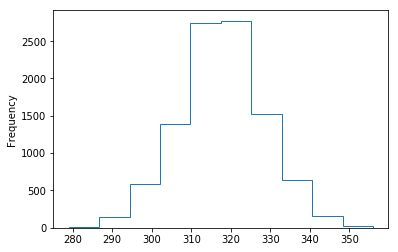

In [189]:
samplingDF['counts'].plot(kind='hist', histtype='step')

* Note that we have generated this distribution under the **"null hypothesis"** that the pumps have nothing to do with the cholera outbreak, and the deaths occured simply proportionally to the population. 
* We can now compare this distribution with the observed number of 340 deaths in area zero. 
* We do this by evaluating the quantile at which we find 340 in this null hypothesis sampling distribution:

In [190]:
scipy.stats.percentileofscore(samplingDF['counts'],340)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1719: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


97.99

* This very high percentile implies that 340 deaths is a very extreme value, which we would not expect from the null scenario.
* Its corresponding P-value is computed as:

In [191]:
100 - scipy.stats.percentileofscore(samplingDF['counts'],340)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1719: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


2.010000000000005

* This means that we would expect this Null Hypothesis to be true only 2% of the time. 
* The smaller the P-value, the more strongly we can reject the null hypothesis. 
* A P-value of 5% is typically used as the cut-off to reject the null hypothesis, but there are debates on how low this cut-off should be.

<a id='p-value'> </a>
## P-Values and Confidence Intervals
* There is in fact a close relationship between hypothesis testing and confidence intervals. 
* If the null hypothesis corresponds to a range of values for a population parameter that is excluded from the confidence interval, then the null hypothesis must be rejected with a very low P-value. 
* The **lower the P-value, the higher the confidence level of the interval**.
* To exemplify this we go back to our example of the election poll and reformulate it as hypothesis testing.

In [46]:
poll = pd.read_csv('poll.csv')
poll['vote'].value_counts(normalize=True)  #this returns the normalized number of votes (proportions) for LSU and Bama. 

Saban      0.511
Orgeron    0.489
Name: vote, dtype: float64

* Here, the null hypothesis will be that Orgeron wins or ties the election. 
* So, the true Saban winning percentage will be 0.50 or less. 
* We need to find out whether a Saban winning percentage of 0.511 is an extreme result if the null hypothesis holds. 
* So we compute the sampling distribution of the proportion, and get a true Saban fraction of 0.50.
* If it's lower than that, the P-value will be even lower. So we can work with 0.50.

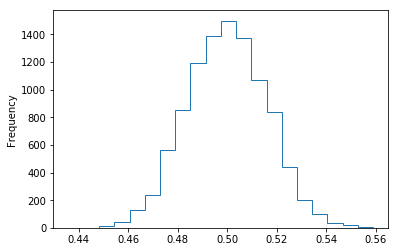

In [49]:
distDF = pd.DataFrame({'Saban': [sample(0.50,1000)['vote'].value_counts(normalize=True)['Saban'] for i in range(10000)]})
distDF['Saban'].plot(kind='hist', histtype='step', bins=20)

In [50]:
100 - scipy.stats.percentileofscore(distDF['Saban'],0.511)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1719: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


24.105000000000004

* This P-value is not low enough to reject the null hypothesis that Ed Orgeron wins or ties the election.
* Recall that the P-value has to be less than 5% to reject the null hypothesis.
* Now we move on to the larger poll

In [51]:
largepoll = pd.read_csv('poll-larger.csv')

In [52]:
largepoll['vote'].value_counts(normalize=True)

Orgeron    0.5181
Saban      0.4819
Name: vote, dtype: float64

* Here, it makes sense to set the null hypothesis to Nick Saban winning or tying since Ed Orgeron seems to have the majority of votes. 
* A **nice feature of binary problems, such as this, is that the null hypothesis and its alternative are complementary**.
* We compute a sampling distribution at the fraction of 0.50, this time for Orgeron.
* This takes longer, so we compute only 1000 repetitions.

In [197]:
dist = pd.DataFrame({'Orgeron': [sample(0.50,10000)['vote'].value_counts(normalize=True)['Orgeron'] for i in range(1000)]})

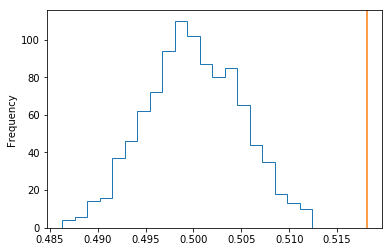

In [198]:
dist['Orgeron'].plot(kind='hist',histtype='step',bins=20)
pp.axvline(0.5181,c='C1')

* Here, the value is so extreme that it is not even included in our finite sampling distribution. 
* We conclude that the P-value for rejecting the null hypothesis that Saban wins or ties is one over 1000 or less, which qualifies as very significant.
* So, we reject the null Hypothesis, and conclude that Ed Orgeron should win the election based on the larger poll.